In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence
import cv2
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.cluster import KMeans
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import *
import glob2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanIoU

In [ ]:
def cvtColor(x):
    x[x < 255] = 0
    return x

In [ ]:
def func(img):
    d = list(map(lambda x: cvtColor(x), img.reshape(-1,3)))
    return np.array(d).reshape(*img.shape[:-1], 3)

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, all_filenames, input_size = (128, 128), batch_size = 8, shuffle = True, seed = 123, encode: dict = None, color_mode = 'hsv', function = None) -> None:
        super(DataGenerator, self).__init__()
        assert encode != None,  'Not empty !'
        assert color_mode == 'hsv' or color_mode == 'rgb' or color_mode == 'gray'
        self.all_filenames = all_filenames
        self.input_size = input_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.color_mode = color_mode
        self.encode = encode
        self.function = function
        np.random.seed(seed)
        self.on_epoch_end()
    def processing(self, mask):
        d = list(map(lambda x: self.encode[tuple(x)], mask.reshape(-1,3)))
        return np.array(d).reshape(*self.input_size, 1)
    def __len__(self):
        return int(np.floor(len(self.all_filenames) / self.batch_size))
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        all_filenames_temp = [self.all_filenames[k] for k in indexes]
        X, Y = self.__data_generation(all_filenames_temp)
        return X, Y
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __data_generation(self, all_filenames_temp):
        batch = len(all_filenames_temp)
        if self.color_mode == 'gray':
            X = np.empty(shape=(batch, *self.input_size, 1))
        else:
            X = np.empty(shape=(batch, *self.input_size,3))
        Y = np.empty(shape=(batch, *self.input_size, 1))
        for i, (fn, label_fn) in enumerate(all_filenames_temp):
            # img
            img = cv2.imread(fn)
            if self.color_mode == 'hsv':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif self.color_mode == 'rgb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif self.color_mode == 'gray':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = tf.expand_dims(img, axis = 2)
            img = tf.image.resize(img, self.input_size, method = 'nearest')
            img = tf.cast(img, tf.float32)
            img /= 255.

            #mask
            mask = cv2.imread(label_fn, 0)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = tf.image.resize(mask, self.input_size, method= 'nearest')
            mask = np.array(mask)
            if self.function:
                mask = self.function(mask)
            mask = self.processing(mask)
            mask = tf.cast(mask, tf.float32)
            X[i,] = img
            Y[i,] = mask
        return X, Y

In [ ]:
def encode_label(mask):
    # input (batch, rows, cols, channels)
    label = []
    for i in mask.reshape(-1,3):
        label.append(tuple(i))
    label = set(label)
    encoder = dict((j,i) for i,j in enumerate(label)) # key is tuple
    with open('label.pickle', 'wb') as handel:
        pickle.dump(encoder, handel, protocol= pickle.HIGHEST_PROTOCOL)
    return encoder
def decode_label(predict, label):
    predict = np.argmax(predict, axis = 3)
    d = list(map( lambda x: label[int(x)], predict.reshape(-1,1)))
    img =  np.array(d).reshape(*predict.shape, 3)
#     b,g,r = cv2.split(img)
#     return cv2.merge((r,g,b))
    return img
def DataLoader(all_train_filename, all_mask,  all_valid_filename = None, input_size = (128,128), batch_size = 4, shuffle = True, seed = 123, color_mode = 'hsv', function = None) -> None:
    mask_folder = sklearn.utils.shuffle(all_mask, random_state = 47)[:16]
    mask = [tf.image.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), input_size, method = 'nearest') for img in mask_folder ]
    mask = np.array(mask)
    if function:
        mask = function(mask)
    encode = encode_label(mask)
    train = DataGenerator(all_train_filename, input_size, batch_size , shuffle, seed, encode, color_mode, function)
    if all_valid_filename == None:
        return train, None
    else:
        valid = DataGenerator(all_valid_filename, input_size, batch_size, shuffle, seed, encode, color_mode, function)
        return train, valid

In [ ]:
def down_block(x, filters, use_maxpool = True):
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    if use_maxpool == True:
        return  MaxPooling2D(strides= (2,2))(x), x
    else:
        return x
def up_block(x,y, filters):
    x = UpSampling2D()(x)
    x = Concatenate(axis = 3)([x,y])
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x

def Unet(input_size = (128, 128, 3), *, classes, dropout):
    filter = [64,128,256,512, 1024]
    # encode
    input = Input(shape = input_size)
    x, temp1 = down_block(input, filter[0])
    x, temp2 = down_block(x, filter[1])
    x, temp3 = down_block(x, filter[2])
    x, temp4 = down_block(x, filter[3])
    x = down_block(x, filter[4], use_maxpool= False)
    # decode
    x = up_block(x, temp4, filter[3])
    x = up_block(x, temp3, filter[2])
    x = up_block(x, temp2, filter[1])
    x = up_block(x, temp1, filter[0])
    x = Dropout(dropout)(x)
    output = Conv2D(classes, 1, activation= 'softmax')(x)
    model = models.Model(input, output, name = 'unet')
    model.summary()
    return model


In [ ]:
from tensorflow.keras.metrics import MeanIoU
import numpy as np
class m_iou():
    def __init__(self, classes: int) -> None:
        self.classes = classes
    def mean_iou(self,y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)
        return miou_keras.result().numpy()
    def miou_class(self, y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)
        values = np.array(miou_keras.get_weights()).reshape(self.classes, self.classes)
        for i in  range(self.classes):
            class_iou = values[i,i] / (sum(values[i,:]) + sum(values[:,i]) - values[i,i])
            print(f'IoU for class{str(i + 1)} is: {class_iou}')

In [ ]:
import matplotlib.pyplot as plt
def show_history(history, validation : bool = False):
    if validation:
        # Loss
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['loss'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_loss'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Loss')
        axes.legend()
        # Acc
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['acc'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_acc'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Acc')
        axes.legend()
        # Mean Iou
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['mean_iou'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_mean_iou'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('MeanIoU')
        axes.legend()
    else:
        fig, axes = plt.subplots(1,4, figsize= (20,5))
        # loss
        axes[0].plot(history.epoch, history.history['loss'])
        axes[0].set_title('Train')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        # Acc
        axes[1].plot(history.epoch, history.history['acc'])
        axes[1].set_title('Train')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Acc')
        # Mean Iou
        axes[2].plot(history.epoch, history.history['mean_iou'])
        axes[2].set_title('Train')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('MeanIoU')

In [ ]:
def predict(model, image_test, label, color_mode, size):
    image = cv2.imread(image_test)
    if color_mode == 'hsv':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_mode == 'rgb':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif color_mode == 'gray':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_cvt = tf.expand_dims(image_cvt, axis = 2)
    image_cvt = tf.image.resize(image_cvt, size, method= 'nearest')
    image_cvt = tf.cast(image_cvt, tf.float32)
    image_norm = image_cvt / 255.
    image_norm = tf.expand_dims(image_norm, axis= 0)
    new_image = model(image_norm)
    image_decode = decode_label(new_image, label)
    predict_img = tf.cast(tf.image.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), size, method = 'nearest'), tf.float32) * 0.7 + image_decode * 0.3
    return np.floor(predict_img)[0].astype('int'), new_image

In [ ]:
def show_example(image, mask, model, label, inp_size, color_mode, function):
    img = cv2.imread(image)
    img = tf.image.resize(img, inp_size, method ='nearest')
    pred, _pred= predict(model, image, label, color_mode, inp_size)
    if mask != None:
        msk= cv2.imread(mask)
        msk= tf.image.resize(msk, inp_size, method = 'nearest')
        if function:
            msk = tf.convert_to_tensor(function(msk.numpy()))
        m.miou_class(train_data.processing(msk.numpy()), _pred)
        ground_truth = np.floor(img.numpy() * 0.7 + msk.numpy() * 0.3).astype('int')
        fig, axes = plt.subplots(1,3, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Ground truth')
        axes[1].imshow(ground_truth)
        axes[2].set_title('Prediction')
        axes[2].imshow(pred)

    else:
        fig, axes = plt.subplots(1,2, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Prediction')
        axes[1].imshow(pred)


In [ ]:
images = sorted(glob2.glob('/content/drive/MyDrive/segmentation_dataset/dataset/train/images/*.jpg'))
masks = sorted(glob2.glob('/content/drive/MyDrive/segmentation_dataset/dataset/train/masks/*.jpg'))
data = list(zip(images, masks))
data = shuffle(data, random_state= 42)
split = int(0.8 * len(data))
all_train_filenames = data[:split]
all_valid_filenames = data[split:]

In [ ]:
train_data, valid_data = DataLoader(all_train_filenames, masks, all_valid_filenames, (128, 128), 8, True, 47, 'gray', function= func)
inp_size = (128, 128, 1)
unet = Unet(inp_size, classes= 2, dropout= 0.3)

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)         0         ['batch_normalization[0][0]

In [ ]:
m = m_iou(2)

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/U_net/unet.h5', monitor= 'val_mean_iou', save_best_only= True, verbose= 1, mode = 'max')
lr_R = ReduceLROnPlateau(monitor= 'loss', patience= 4, verbose= 1, factor= 0.3, min_lr= 0.00001)

In [ ]:
unet.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), metrics= [m.mean_iou, 'acc'], run_eagerly= True)
history = unet.fit(train_data, validation_data= valid_data, epochs= 25, verbose= 1, callbacks = [checkpoint, lr_R])

Epoch 1/25


96/96 [==============================] - ETA: 0s - loss: 0.3896 - mean_iou: 0.4431 - acc: 0.8534
Epoch 1: val_mean_iou improved from -inf to 0.44265, saving model to /content/drive/MyDrive/U_net/unet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


96/96 [==============================] - 160s 1s/step - loss: 0.3896 - mean_iou: 0.4431 - acc: 0.8534 - val_loss: 0.3585 - val_mean_iou: 0.4426 - val_acc: 0.8745 - lr: 0.0010
Epoch 2/25
96/96 [==============================] - ETA: 0s - loss: 0.3287 - mean_iou: 0.4529 - acc: 0.8814
Epoch 2: val_mean_iou improved from 0.44265 to 0.47301, saving model to /content/drive/MyDrive/U_net/unet.h5
96/96 [==============================] - 153s 2s/step - loss: 0.3287 - mean_iou: 0.4529 - acc: 0.8814 - val_loss: 0.3739 - val_mean_iou: 0.4730 - val_acc: 0.8442 - lr: 0.0010
Epoch 3/25
96/96 [==============================] - ETA: 0s - loss: 0.3191 - mean_iou: 0.4637 - acc: 0.8824
Epoch 3: val_mean_iou did not improve from 0.47301
96/96 [==============================] - 146s 2s/step - loss: 0.3191 - mean_iou: 0.4637 - acc: 0.8824 - val_loss: 0.3597 - val_mean_iou: 0.4685 - val_acc: 0.8596 - lr: 0.0010
Epoch 4/25
96/96 [==============================] - ETA: 0s - loss: 0.3136 - mean_iou: 0.4726 - acc

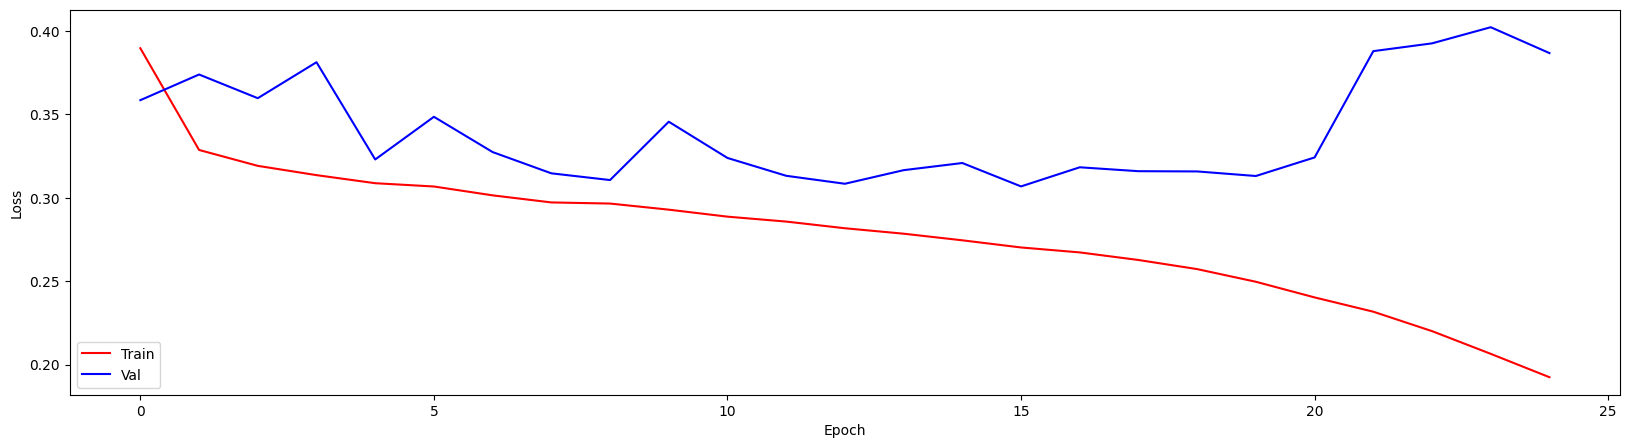

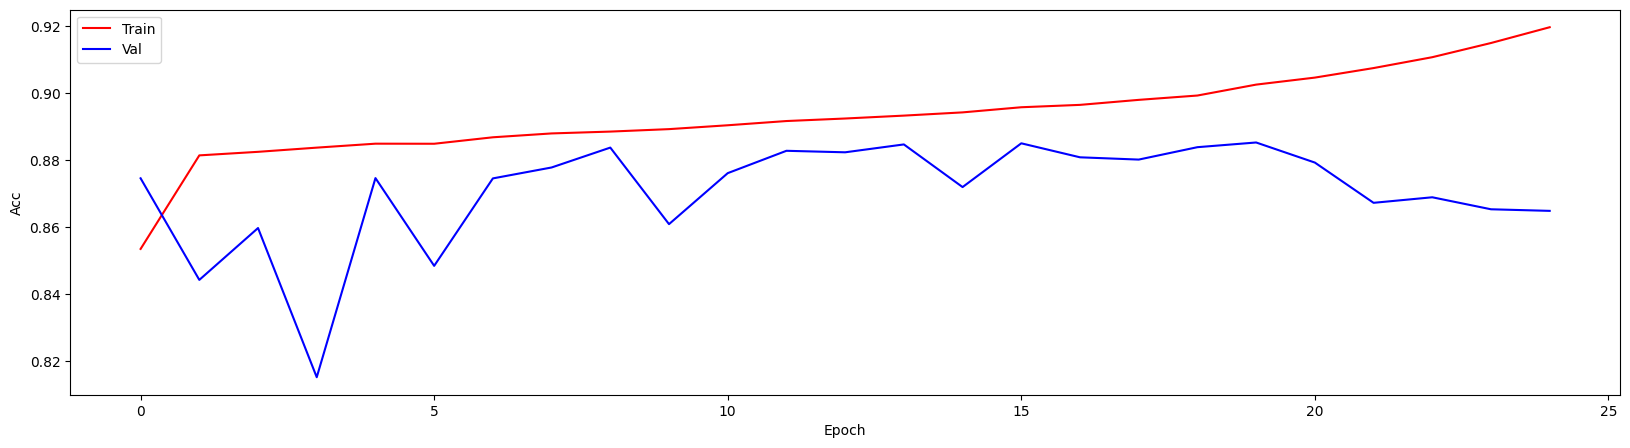

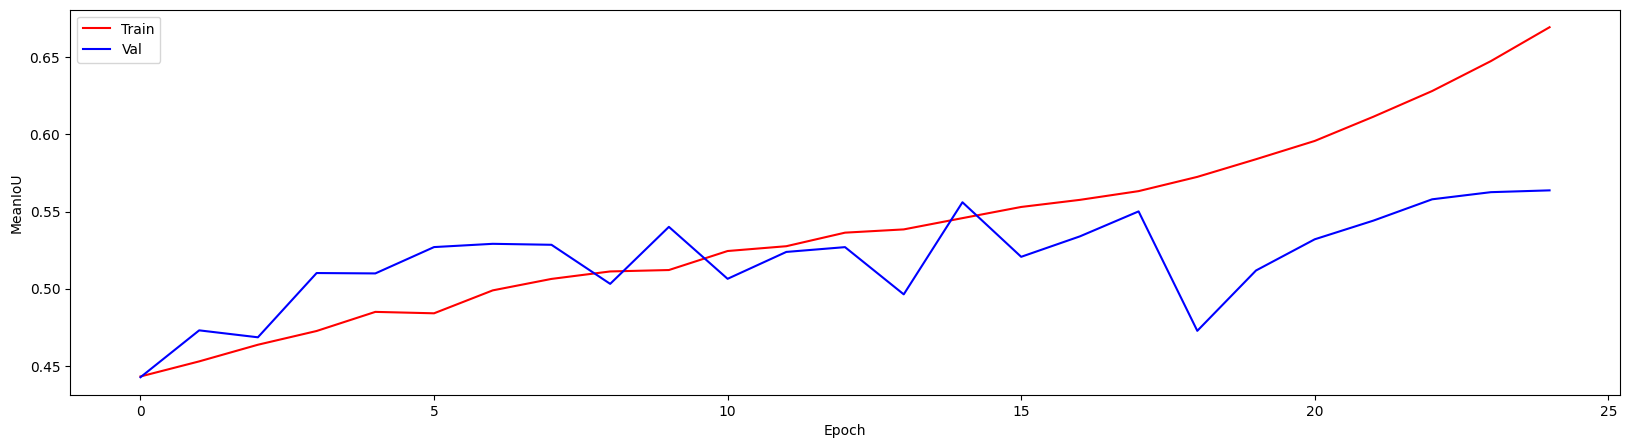

In [ ]:
show_history(history, True)

In [ ]:
with open('label.pickle', 'rb') as handel:
    k = pickle.load(handel)

In [ ]:
encode = dict((j,list(i)) for i,j in k.items())

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/U_net/unet.h5', custom_objects = {'mean_iou': m.mean_iou})

IoU for class1 is: 0.9418363107602825
IoU for class2 is: 0.698058950395399


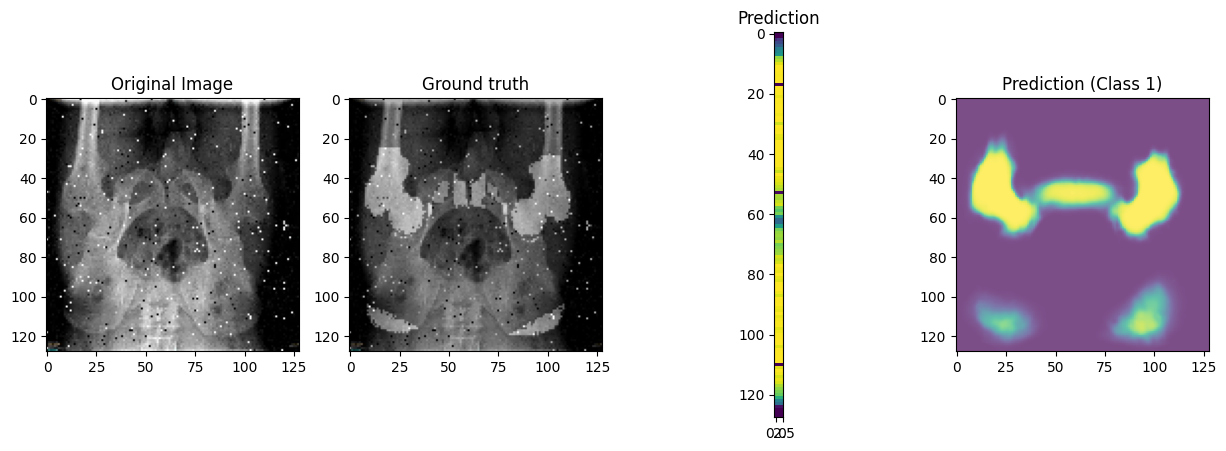

In [ ]:
show_example(*all_train_filenames[6], model, encode, (128,128), 'gray', func)

IoU for class1 is: 0.9528169014084507
IoU for class2 is: 0.7652417659425368


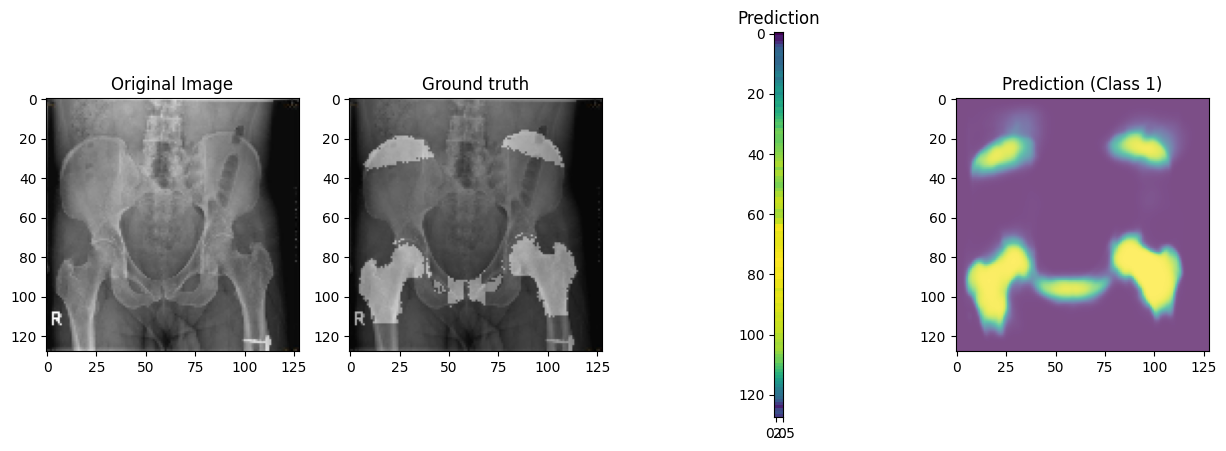

In [ ]:
show_example(*all_train_filenames[2], model, encode, (128,128), 'gray', func)


IoU for class1 is: 0.9359961829459478
IoU for class2 is: 0.6459276018099548


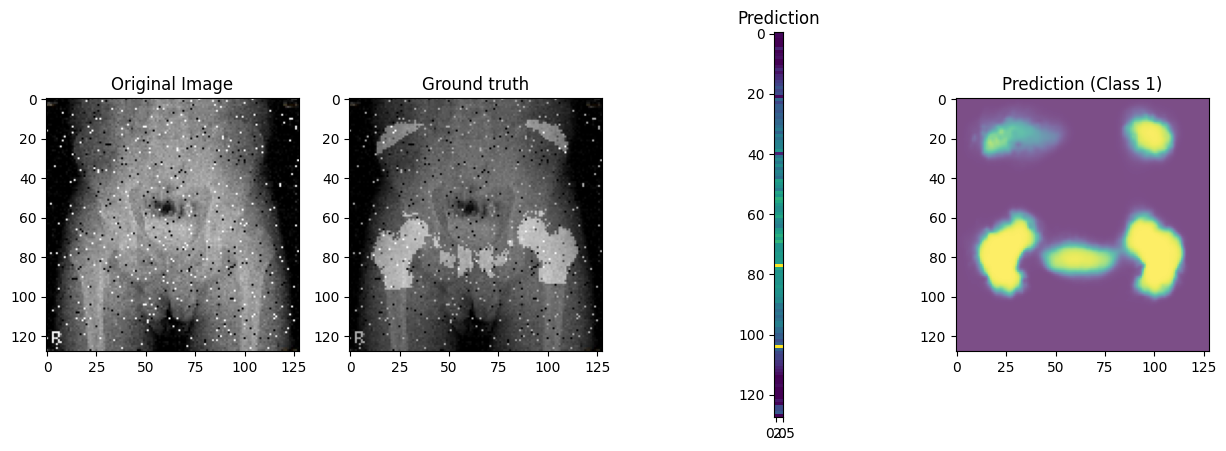

In [ ]:
show_example(*all_train_filenames[5], model, encode, (128,128), 'gray', func)

IoU for class1 is: 0.9437550579983814
IoU for class2 is: 0.6510460251046025


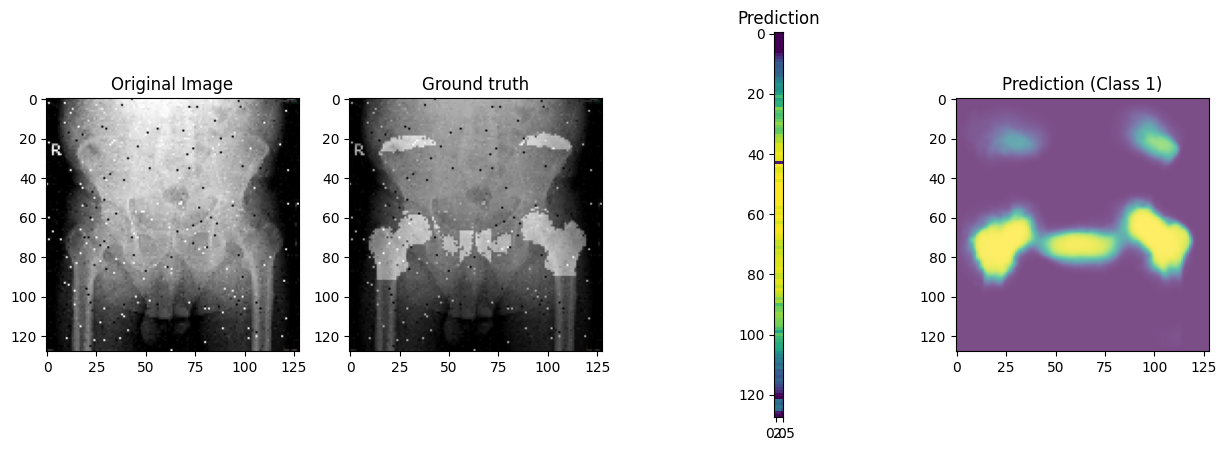

In [ ]:
show_example(*all_train_filenames[7], model, encode, (128,128), 'gray', func)

IoU for class1 is: 0.9061960483406868
IoU for class2 is: 0.3367992766726944


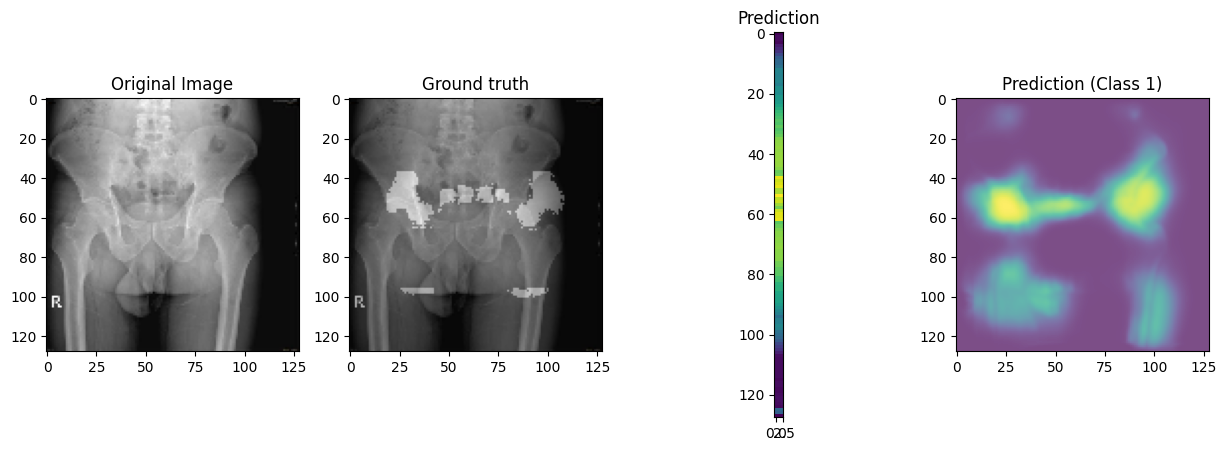

In [ ]:
show_example(*all_train_filenames[10], model, encode, (128,128), 'gray', func)

IoU for class1 is: 0.7694576952046196
IoU for class2 is: 0.10957575757575758


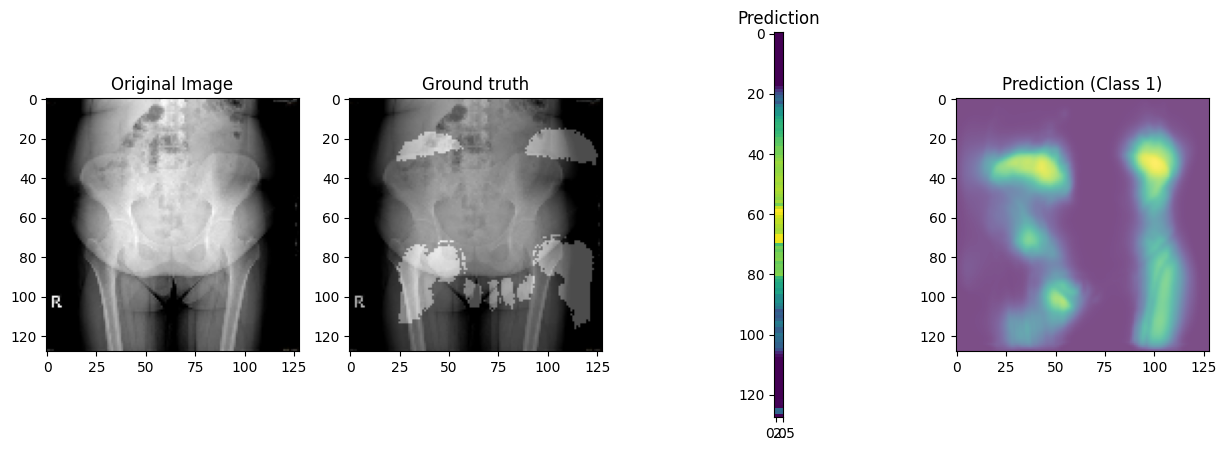

IoU for class1 is: 0.8986715466992002
IoU for class2 is: 0.5216


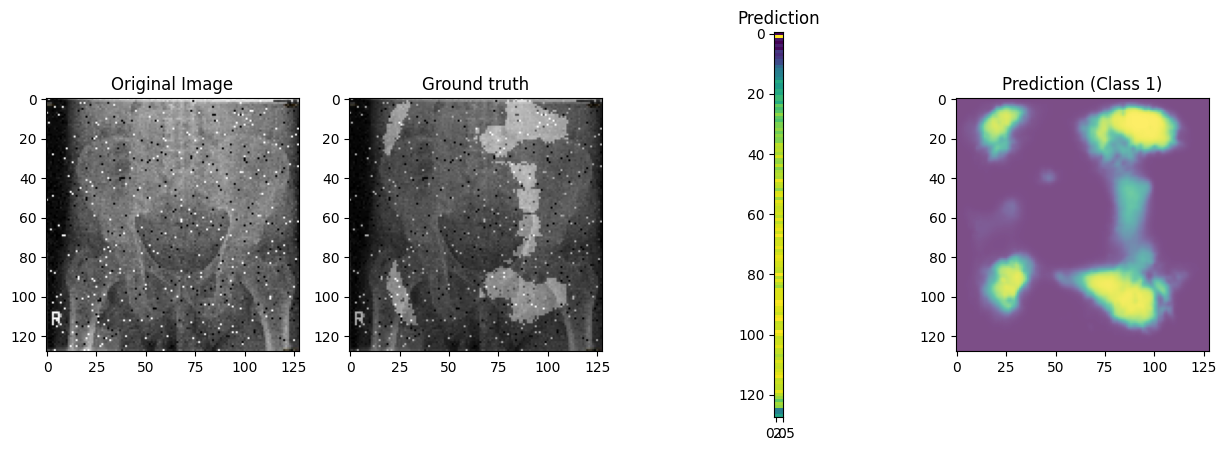

IoU for class1 is: 0.9528169014084507
IoU for class2 is: 0.7652417659425368


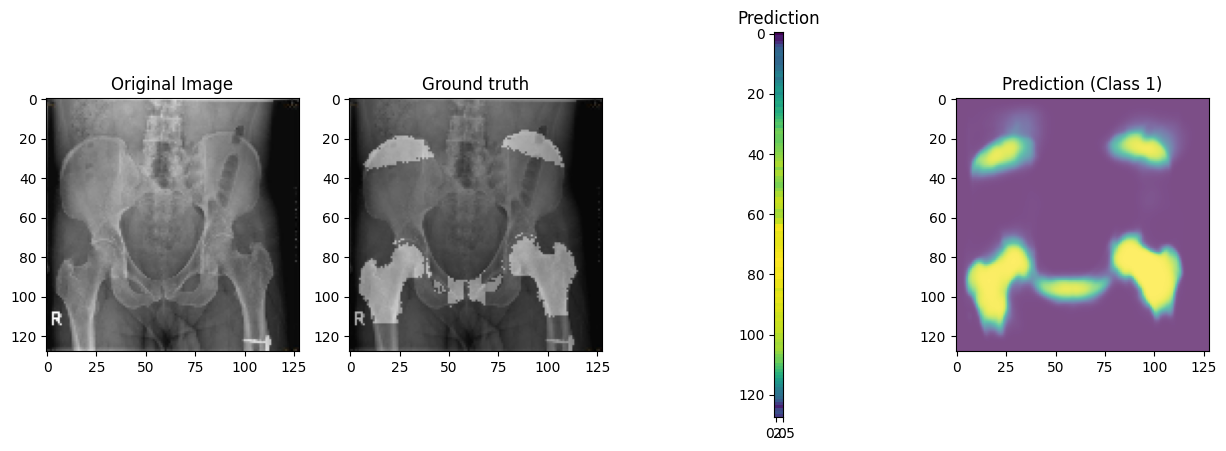

IoU for class1 is: 0.9183878460669219
IoU for class2 is: 0.25925925925925924


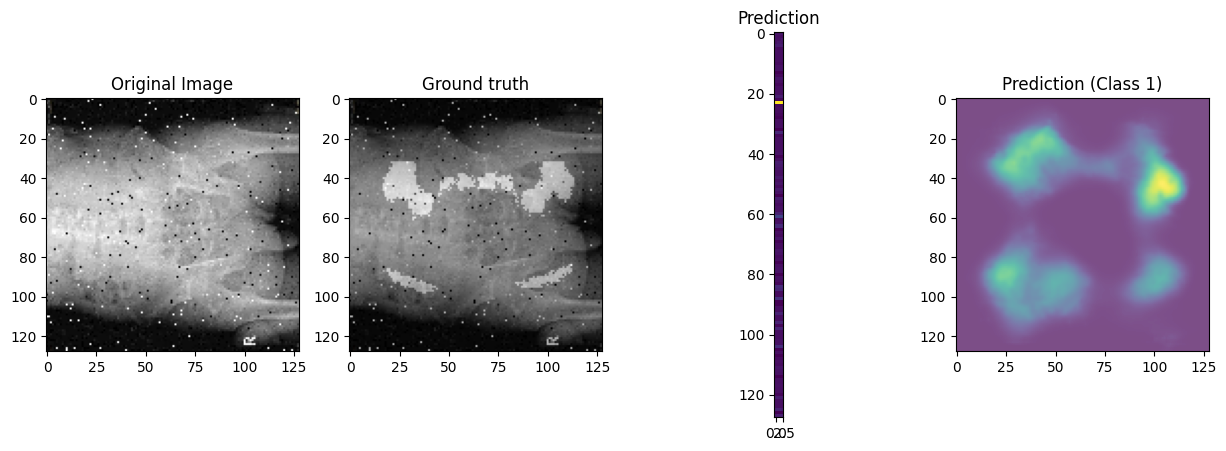

IoU for class1 is: 0.8287831252920366
IoU for class2 is: 0.35357862903225806


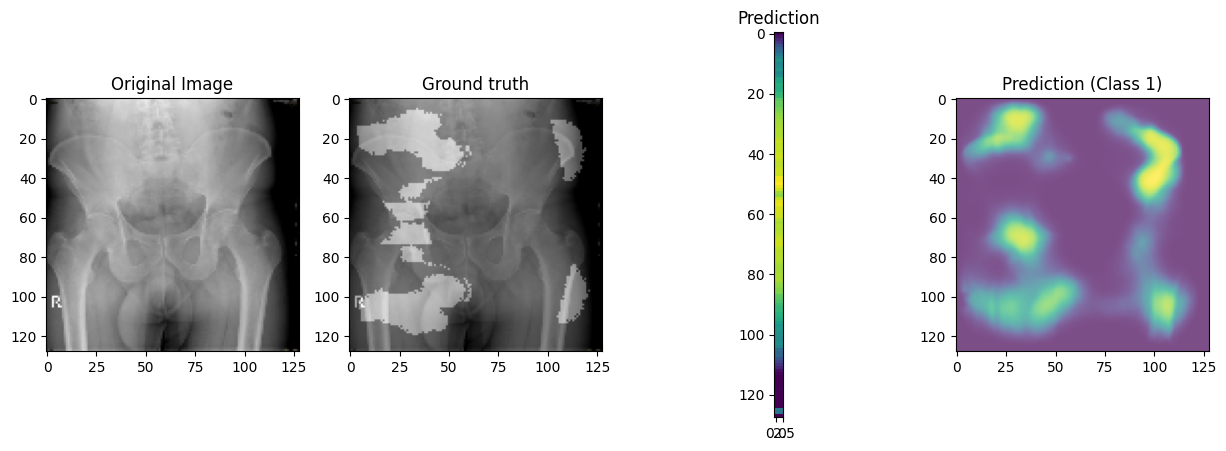

In [ ]:
for i in range(5):
    show_example(*all_train_filenames[i], model, encode, (128,128), 'gray', func)


IoU for class1 is: 0.7694576952046196
IoU for class2 is: 0.10957575757575758


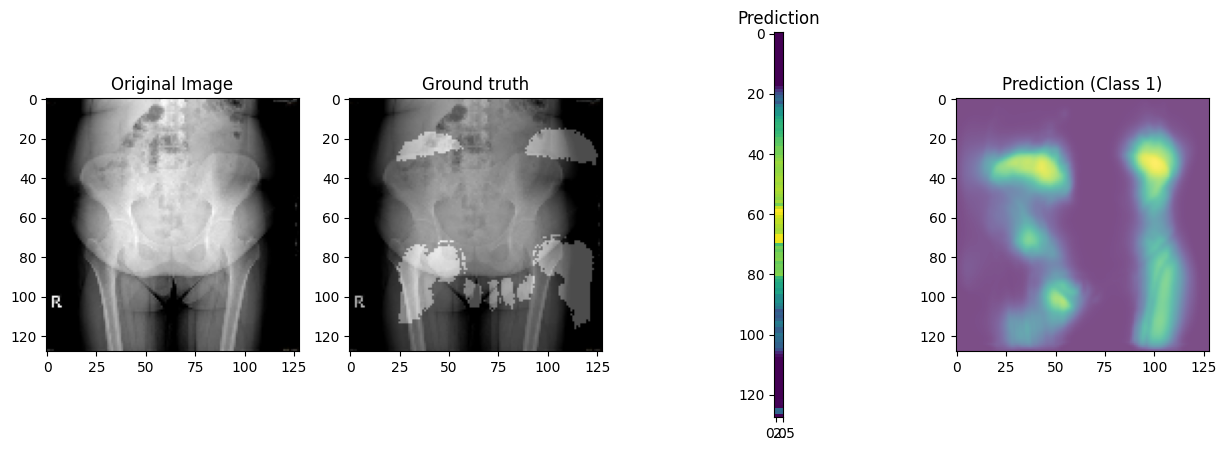

IoU for class1 is: 0.8986715466992002
IoU for class2 is: 0.5216


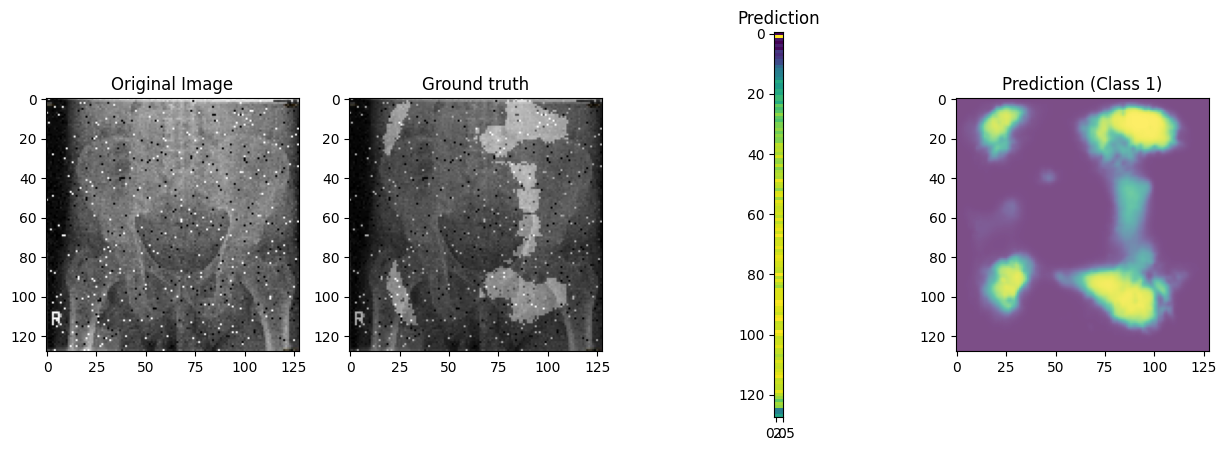

IoU for class1 is: 0.9528169014084507
IoU for class2 is: 0.7652417659425368


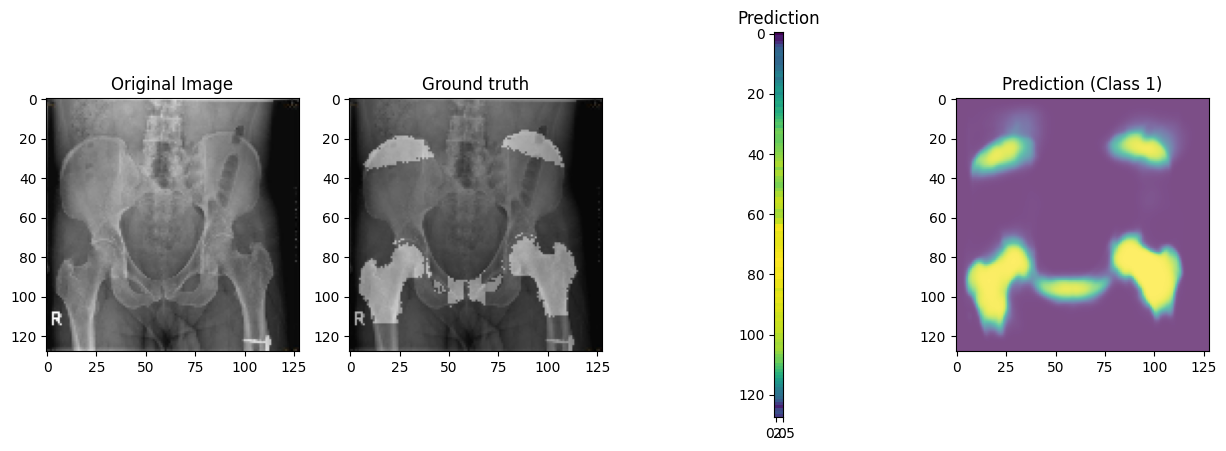

IoU for class1 is: 0.9183878460669219
IoU for class2 is: 0.25925925925925924


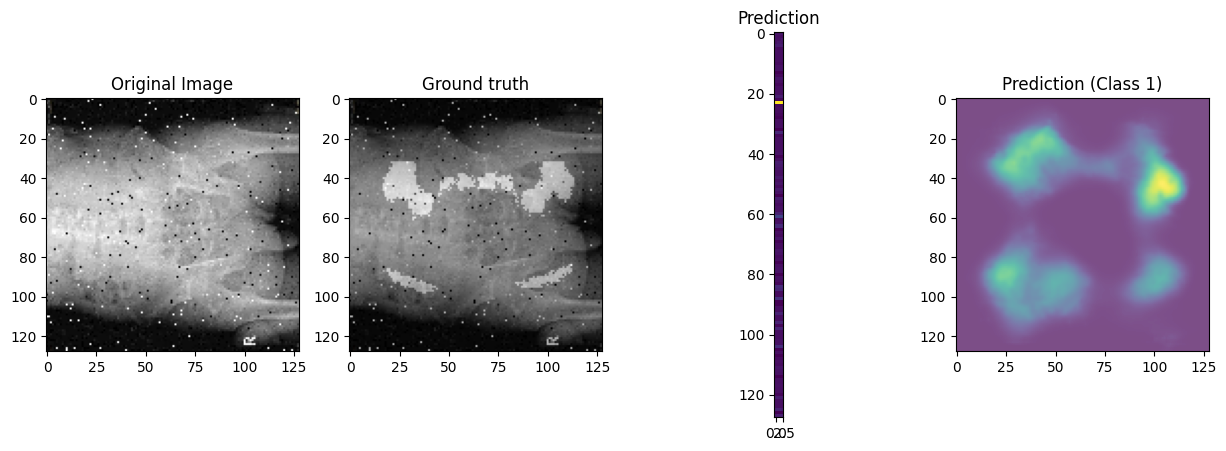

IoU for class1 is: 0.8287831252920366
IoU for class2 is: 0.35357862903225806


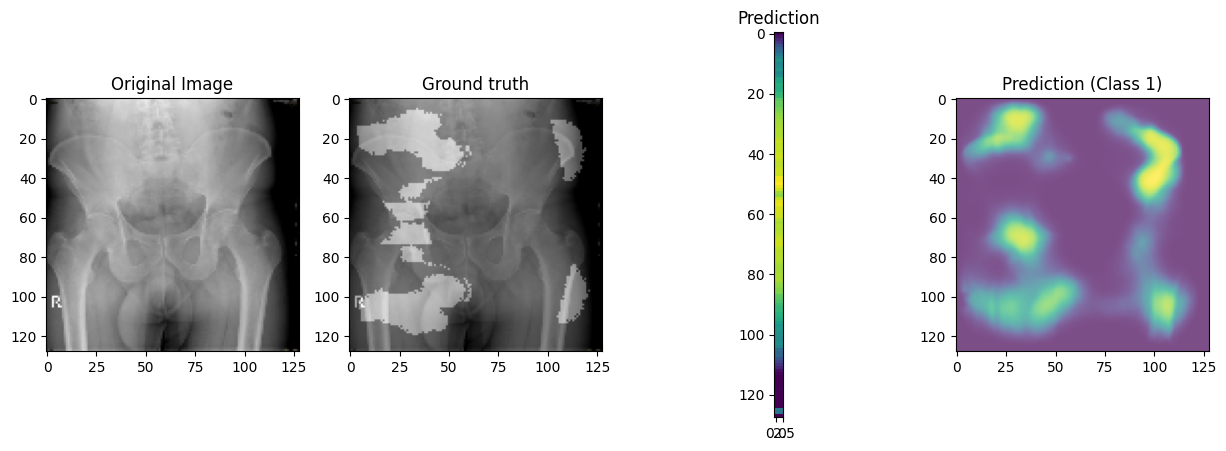

In [ ]:
def show_example(image, mask, model, label, inp_size, color_mode, function):
    img = cv2.imread(image)
    img = tf.image.resize(img, inp_size, method='nearest')
    pred, _pred = predict(model, image, label, color_mode, inp_size)
    if mask is not None:
        msk = cv2.imread(mask)
        msk = tf.image.resize(msk, inp_size, method='nearest')
        if function:
            msk = tf.convert_to_tensor(function(msk.numpy()))
        m.miou_class(train_data.processing(msk.numpy()), _pred)
        ground_truth = np.floor(img.numpy() * 0.7 + msk.numpy() * 0.3).astype('int')
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Ground truth')
        axes[1].imshow(ground_truth)
        axes[2].set_title('Prediction')
        axes[2].imshow(pred)
        axes[3].set_title('Prediction (Class 1)')
        axes[3].imshow(_pred[0, :, :, 1], cmap='viridis', alpha=0.7)
    else:
        fig, axes = plt.subplots(1, 3, figsize=(12, 3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Prediction')
        axes[1].imshow(pred)

    plt.show()

# Now, use a loop to display multiple examples
for example_filename in all_train_filenames[:5]:
    show_example(*example_filename, model, encode, (128,128), 'gray', func)

